### 통계 기반 기법의 문제점(Co-occurrence Matrix + PPMI + SVD)
- 대규모 말뭉치를 다루기 어려움
- 영어의 어휘가 대략 100만개를 넘음
- 이때, 100만 * 100만 행렬을 만들고 SVD 계산 어려움

**대량의 어휘를 한번에 분석하지 않아도 되는 기법 필요 $\rightarrow$ 딥러닝은 미니배치 학습 사용 가능**

### CBOW(Continuous Bag of Words)
- 주변 단어들을 입력으로 받아 중심 단어를 예측하는 추론 기반 임베딩 학습 기법

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
text = "You say goodbye and I say hello"

In [4]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = [word_to_id[word] for word in words]

  return corpus, word_to_id, id_to_word

In [5]:
corpus, word_to_id, id_to_word = preprocess(text)

In [6]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []
  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size+1):
      if t == 0:
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [8]:
def one_hot_encode(indices, vocab_size):
  indices = np.array(indices)
  shape = indices.shape
  one_hot = np.zeros(shape + (vocab_size,), dtype = np.float32)
  it = np.ndindex(shape)
  for idx in it:
    one_hot[idx + (indices[idx],)] = 1.0

  return one_hot

In [9]:
vocab_size = len(word_to_id)
convert_contexts = one_hot_encode(contexts, vocab_size)

convert_contexts = torch.tensor(convert_contexts)
convert_target = torch.tensor(target, dtype = torch.long)

In [10]:
class CBOWModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super().__init__()
    self.embedding = nn.Linear(vocab_size, embedding_dim, bias = False)
    self.output = nn.Linear(embedding_dim, vocab_size, bias = False)

  def forward(self, x):
    emb = self.embedding(x)
    avg = torch.mean(emb, dim = 1)
    x = self.output(avg)
    return x

왜 여러개의 단어 임베팅 벡터를 평균내서 하나의 벡터로 만드는가?
1. 고정 크기 입력을 위해 (중심 단어 예측의 입력)
2. 순서를 고려하지 않는 Bag-of-Words 구조
3. 학습 안정성과 직관성

In [11]:
torch.cuda.manual_seed(123)
model = CBOWModel(vocab_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
epochs = 20000
for epoch in range(epochs):
  optimizer.zero_grad()
  outputs = model(convert_contexts)
  loss_model = criterion(outputs, convert_target)
  loss_model.backward()
  optimizer.step()

  pred = torch.argmax(outputs, dim = 1)

  train_loss = loss_model.item()
  train_acc = (pred == convert_target).float().mean()
  if epoch%100 == 0:
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.5f}, Accuracy: {train_acc:.5f}')

Epoch: 1/20000, Loss: 1.79342, Accuracy: 0.20000
Epoch: 101/20000, Loss: 1.73614, Accuracy: 0.60000
Epoch: 201/20000, Loss: 1.64259, Accuracy: 0.60000
Epoch: 301/20000, Loss: 1.49565, Accuracy: 0.80000
Epoch: 401/20000, Loss: 1.32620, Accuracy: 0.80000
Epoch: 501/20000, Loss: 1.15452, Accuracy: 0.80000
Epoch: 601/20000, Loss: 0.98252, Accuracy: 0.80000
Epoch: 701/20000, Loss: 0.81912, Accuracy: 0.80000
Epoch: 801/20000, Loss: 0.68158, Accuracy: 0.80000
Epoch: 901/20000, Loss: 0.57875, Accuracy: 0.80000
Epoch: 1001/20000, Loss: 0.50606, Accuracy: 0.80000
Epoch: 1101/20000, Loss: 0.45478, Accuracy: 0.80000
Epoch: 1201/20000, Loss: 0.41792, Accuracy: 0.80000
Epoch: 1301/20000, Loss: 0.39083, Accuracy: 0.80000
Epoch: 1401/20000, Loss: 0.37045, Accuracy: 0.80000
Epoch: 1501/20000, Loss: 0.35482, Accuracy: 0.80000
Epoch: 1601/20000, Loss: 0.34259, Accuracy: 0.80000
Epoch: 1701/20000, Loss: 0.33288, Accuracy: 0.80000
Epoch: 1801/20000, Loss: 0.32504, Accuracy: 0.80000
Epoch: 1901/20000, Loss:

In [13]:
word_vectors = model.embedding.weight.T
word_vectors

tensor([[-2.0562, -4.6107],
        [ 3.2718, -2.5571],
        [-2.4970,  2.2702],
        [ 3.5252, -3.1685],
        [-2.5957,  1.9511],
        [-2.1934, -4.2464]], grad_fn=<PermuteBackward0>)

In [14]:
import torch.nn.functional as F

In [15]:
def most_similar(word, model_embedding, word_to_id, id_to_word, topk = 5):
  if word not in word_to_id:
    print("단어가 존재하지 않음")
    return

  word_id = word_to_id[word]
  with torch.no_grad():
    emb = model_embedding.weight.T
    target_vec = emb[word_id]
    scores = F.cosine_similarity(target_vec.unsqueeze(0), emb)
    topk_ids = torch.topk(scores, topk + 1).indices.tolist()

    result = []
    for idx in topk_ids:
      if idx != word_id:
        result.append((id_to_word[idx], scores[idx].item()))
        if len(result) == topk:
          break

  return result

In [16]:
similarites = most_similar('you', model.embedding, word_to_id, id_to_word, topk = 5)

In [17]:
for word, sim in similarites:
  print(f'{word}: {sim:.4f}')

hello: 0.9984
and: 0.3076
say: 0.2415
i: -0.2232
goodbye: -0.3130


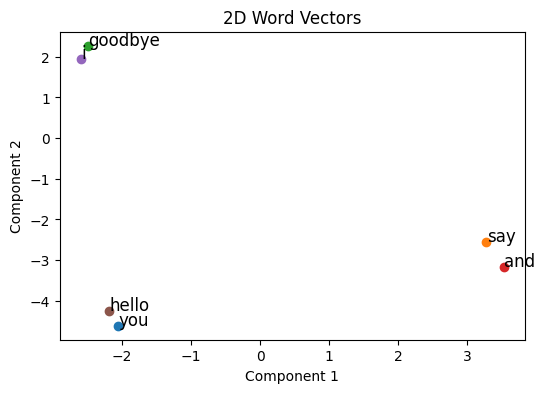

In [18]:
with torch.no_grad():
  plt.figure(figsize = (6, 4))
  for i, word in id_to_word.items():
    plt.scatter(word_vectors[i, 0], word_vectors[i, 1])
    plt.text(word_vectors[i, 0]+0.01, word_vectors[i, 1]+0.01, word, fontsize=12)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.title('2D Word Vectors')
  plt.show()

In [19]:
def load_text(filepath):
  with open(filepath, 'r', encoding = 'utf-8') as f:
    return f.read()

In [20]:
text = load_text('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/NLP/text.txt')

In [21]:
def preprocess(text):
  text = text.lower()
  # 괄호, 쉼표, 마침표 등 구두점 제거
  text = re.sub(r'[^\w\s]', '', text)
  # 줄바꿈 제거
  text = text.replace('\n', ' ')
  words = text.split(' ')
  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = [word_to_id[word] for word in words]
  return corpus, word_to_id, id_to_word

In [22]:
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=5)
vocab_size = len(id_to_word)
convert_contexts = one_hot_encode(contexts, vocab_size)
convert_contexts = torch.tensor(convert_contexts)
convert_target = torch.tensor(target, dtype=torch.long)

In [23]:
class CBOWModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super().__init__()
    self.embedding = nn.Linear(vocab_size, embedding_dim, bias = False)
    self.output = nn.Linear(embedding_dim, vocab_size, bias = False)

  def forward(self, x):
    emb = self.embedding(x)
    avg = torch.mean(emb, dim=1)
    x = self.output(avg)
    return x

In [24]:
torch.cuda.manual_seed(123)
model = CBOWModel(vocab_size, embedding_dim = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [25]:
epochs = 30000
for epoch in range(epochs):
  optimizer.zero_grad()
  outputs = model(convert_contexts)
  loss_model = criterion(outputs, convert_target)
  loss_model.backward()
  optimizer.step()

  pred = torch.argmax(outputs, dim = 1)

  train_loss = loss_model.item()
  train_acc = (pred == convert_target).float().mean()
  if epoch%1000 == 0:
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.5f}, Accuracy: {train_acc:.5f}')

Epoch: 1/30000, Loss: 4.21980, Accuracy: 0.00000
Epoch: 1001/30000, Loss: 3.28590, Accuracy: 0.10667
Epoch: 2001/30000, Loss: 2.82186, Accuracy: 0.14667
Epoch: 3001/30000, Loss: 2.54406, Accuracy: 0.18667
Epoch: 4001/30000, Loss: 2.31112, Accuracy: 0.25333
Epoch: 5001/30000, Loss: 2.10019, Accuracy: 0.30667
Epoch: 6001/30000, Loss: 1.91925, Accuracy: 0.33333
Epoch: 7001/30000, Loss: 1.76988, Accuracy: 0.34667
Epoch: 8001/30000, Loss: 1.63814, Accuracy: 0.40000
Epoch: 9001/30000, Loss: 1.52070, Accuracy: 0.46667
Epoch: 10001/30000, Loss: 1.41016, Accuracy: 0.50667
Epoch: 11001/30000, Loss: 1.30882, Accuracy: 0.57333
Epoch: 12001/30000, Loss: 1.21986, Accuracy: 0.58667
Epoch: 13001/30000, Loss: 1.13913, Accuracy: 0.60000
Epoch: 14001/30000, Loss: 1.06510, Accuracy: 0.66667
Epoch: 15001/30000, Loss: 0.99697, Accuracy: 0.68000
Epoch: 16001/30000, Loss: 0.93383, Accuracy: 0.70667
Epoch: 17001/30000, Loss: 0.87547, Accuracy: 0.72000
Epoch: 18001/30000, Loss: 0.82151, Accuracy: 0.72000
Epoch:

In [26]:
word_vectors = model.embedding.weight.T

In [29]:
similarities = most_similar('artificial', model.embedding, word_to_id, id_to_word, topk = 20)

In [30]:
for word, sim in similarities:
  print(f'{word}: {sim:.4f}')

new: 1.0000
experts: 0.9999
computer: 0.9999
believe: 0.9998
traditional: 0.9997
intelligence: 0.9997
design: 0.9993
will: 0.9851
the: 0.9338
landscape: 0.9176
rapidly: 0.8979
as: 0.8168
technological: 0.7950
lies: 0.7745
ai: 0.7272
transforming: 0.6704
replace: 0.6635
technologies: 0.6588
employment: 0.4870
major: 0.4222


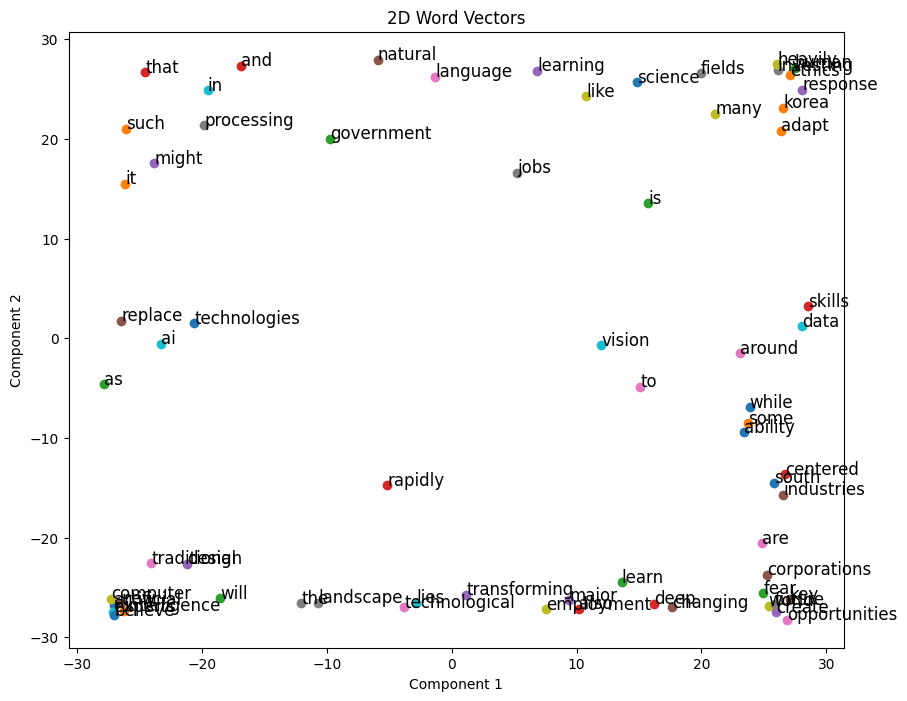

In [31]:
with torch.no_grad():
  plt.figure(figsize = (10, 8))
  for i, word in id_to_word.items():
    plt.scatter(word_vectors[i, 0], word_vectors[i, 1])
    plt.text(word_vectors[i, 0]+0.01, word_vectors[i, 1]+0.01, word, fontsize=12)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.title('2D Word Vectors')
  plt.show()

In [32]:
from sklearn.datasets import fetch_20newsgroups

In [33]:
dataset = fetch_20newsgroups(shuffle = True, remove = ('headers', 'footers', 'quotes'))
documents = dataset.data
corpus, word_to_id, id_to_word = preprocess(". ".join(documents))

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
def context_target(coupus, window_size):
  dataset = []
  for idx in range(window_size, len(corpus) - window_size):
    context = (
        corpus[idx - window_size: idx] + corpus[idx + 1: idx + window_size + 1]
    )
    target = corpus[idx]
    dataset.append((context, target))

  return dataset

In [36]:
dataset = context_target(corpus, window_size = 5)

In [37]:
class CBOWDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    context, target = self.data[idx]
    return torch.tensor(context, dtype = torch.long), torch.tensor(target, dtype = torch.long)

In [38]:
cbow_dataset = CBOWDataset(dataset)
dataloader = DataLoader(cbow_dataset, batch_size = 128, shuffle = True)

In [39]:
class CBOWModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.output = nn.Linear(embedding_dim, vocab_size)

  def forward(self, context_idxs):
    emb = self.embedding(context_idxs)
    context_embeds = emb.mean(dim=1)
    out = self.output(context_embeds)
    return out

In [40]:
vocab_size = len(word_to_id)
model = CBOWModel(vocab_size, embedding_dim = 100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
epochs = 100
for epoch in range(epochs):
  total_loss = 0
  num = 0
  for context_batch, target_batch in dataloader:
    output = model(context_batch.to(device))
    loss = criterion(output, target_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  if (epoch) % 1 == 0:
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {total_loss:.5f}')

Epoch: 1/100, Loss: 125354.07199
Epoch: 2/100, Loss: 109559.22651
Epoch: 3/100, Loss: 100537.34431
Epoch: 4/100, Loss: 94840.53778
Epoch: 5/100, Loss: 90988.38992
Epoch: 6/100, Loss: 88128.01088
Epoch: 7/100, Loss: 86010.77797
Epoch: 8/100, Loss: 84414.16973
Epoch: 9/100, Loss: 83187.54124
Epoch: 10/100, Loss: 82202.14264
Epoch: 11/100, Loss: 81404.37030
Epoch: 12/100, Loss: 80772.71947
Epoch: 13/100, Loss: 80257.26226
Epoch: 14/100, Loss: 79811.76573
Epoch: 15/100, Loss: 79463.00425
Epoch: 16/100, Loss: 79129.90737
Epoch: 17/100, Loss: 78890.53644
Epoch: 18/100, Loss: 78640.36511
Epoch: 19/100, Loss: 78472.93490
Epoch: 20/100, Loss: 78296.78888
Epoch: 21/100, Loss: 78164.45875
Epoch: 22/100, Loss: 78016.02104
Epoch: 23/100, Loss: 77899.86896
Epoch: 24/100, Loss: 77793.70816
Epoch: 25/100, Loss: 77690.11479
Epoch: 26/100, Loss: 77604.07904


In [ ]:
def most_similar(word, model_embedding, word_to_id, id_to_word, topk = 5):
  if word not in word_to_id:
    print("단어가 존재하지 않음")
    return

  word_id = word_to_id[word]
  with torch.no_grad():
    emb = model_embedding.weight
    target_vec = emb[word_id]
    scores = F.cosine_similarity(target_vec.unsqueeze(0), emb)
    topk_ids = torch.topk(scores, topk + 1).indices.tolist()

    result = []
    for idx in topk_ids:
      if idx != word_id:
        result.append((id_to_word[idx], scores[idx].item()))
        if len(result) == topk:
          break

  return result